## Final Project Submission

Please fill out:
* Student name: Arseniy Tyurin
* Student pace: self paced
* Scheduled project review date/time: September 9, 2019, 6:00pm (GMT-4)
* Instructor name: Eli Thomas
* Blog post URL: <a href="https://medium.com/@arseniytyurin/using-keras-for-predicting-patients-condition-14ba65fb27c5" target="_blank">Using Keras for Predicting Patients Condition</a>


# Introduction

Deep learning has wide variety of application and has gained reputation for image recognition and NLP. As computation power becomes more affordable, deep neural networks constantly evolving with help of big tech companies and R&D scientists.

This project make use of deep learning for NLP to solve classification problem based on patients review of the drug they've used.

# Goal

The goal for this project is to make predictions of the drugs patients used and to answer following **questions**:

- Has older reviews been more useful to the readers?
- How rating of the drug affects usefulness of the review?
- Is it possible to distinguish drugs from the same category (ex. Birth Control)?

# Dataset Description

<a href="https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018" target="_blank">The UCI ML Drug Review dataset</a> provides patient reviews on specific drugs along with related conditions and a 10-star patient rating system reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

- **uniqueID** - Unique ID
- **drugName** - Name of drug
- **condition** - Name of condition
- **review** - Patient review
- **rating** - 10 star patient rating
- **date** - Date of review entry
- **usefulCount** - Number of users who found review useful

# Data Science Process

A successful completion of the analysis requires clear understanding of business problem.
For this project I'm going to use <a href="https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492" target="_blank">OSEMN Framework</a> (Obtain - Scrab - Explore - Model - Interpret), which is one of the most common ways of doing analysis and building predictive models.

# Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import random

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from nltk.collocations import *
#from nltk import FreqDist, word_tokenize

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing

from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Activation, LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout, Conv1D
from keras.models import Sequential, Model
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
from keras import backend
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import warnings
warnings.filterwarnings('ignore')

# 1. Obtain

Data is stored in csv files and split into two parts: train and test. For the sake of flexibility and to preprocess data all at once I concatenated them into one dataframe

In [4]:
drug_review_train = pd.read_csv('data/drugsComTrain_raw.csv')
drug_review_test = pd.read_csv('data/drugsComTest_raw.csv')

In [127]:
# combining train and test data to have more flexibility during testing phase and to ease scrubbing step.
drugs = pd.concat([drug_review_test, drug_review_train])
drugs.reset_index(inplace=True)

# 2. Scrub

## 2.1 Checking for missing values

In [6]:
drugs.isna().sum()

index             0
uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [7]:
# Though missing condition could be a good way to test NN, I would have no way to validate my predictions
# So I decided to drop missing values
drugs.dropna(inplace=True)

## 2.2 Converting `date` to datetime type

In [8]:
# For time-series analysis
drugs.date = pd.to_datetime(drugs.date)

In [9]:
drugs.date = pd.to_datetime(drugs.date)
drugs['year'] = drugs.date.dt.year

## 2.3 Cleaning and Lemmatization of `review` column

Removing html tags, special characters, punctuation, stopwords and lowering the case. Final phase is lemmatization.

In [10]:
drugs.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,year
0,0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,2012
1,1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17,2009
2,2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3,2017
3,3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35,2017
4,4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4,2015


In [11]:
drugs.review = drugs.review.str.lower()
drugs.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,year
0,0,163740,Mirtazapine,Depression,"""i&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,2012
1,1,206473,Mesalamine,"Crohn's Disease, Maintenance","""my son has crohn&#039;s disease and has done ...",8,2009-05-17,17,2009
2,2,159672,Bactrim,Urinary Tract Infection,"""quick reduction of symptoms""",9,2017-09-29,3,2017
3,3,39293,Contrave,Weight Loss,"""contrave combines drugs that were used for al...",9,2017-03-05,35,2017
4,4,97768,Cyclafem 1 / 35,Birth Control,"""i have been on this birth control for one cyc...",9,2015-10-22,4,2015


### Removing punctuation and special characters

In [12]:
drugs.review = drugs.review.str.replace('&#039;', "'")
drugs.review = drugs.review.str.replace('&\w+;',' ')
drugs.review = drugs.review.str.replace(r"[^a-z'A-Z]+", " ")

### Removing stop words and lemmatizing text

In [13]:
def text_to_tokens(text):
    stopwords_list = stopwords.words('english') 
    stopwords_list += [i for i in ["i'm", "i've", "mg", "ml","'ve","'s", "can't", "i'd", "that's", "ya'll", "get's"]]
    return [i for i in list(set(text.split())) if i not in stopwords_list]

def lemm(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    string = ''
    for word in text:
        string += wordnet_lemmatizer.lemmatize(word, pos="v")+' '
    return string.strip()

In [15]:
tokens = drugs.review.map(text_to_tokens)

In [16]:
drugs['lemm_review'] = tokens.map(lemm)

In [17]:
drugs.lemm_review = drugs.lemm_review.str.replace("'", "")

## 2.4 Saving Clean Dataset

In [19]:
drugs.to_csv('data/drug_review_clean.csv', index=False)

# 3. Explore

In [20]:
drugs.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,year,lemm_review
0,0,163740,Mirtazapine,Depression,i've tried a few antidepressants over the yea...,10,2012-02-28,22,2012,insomnia life years gain side fluoxetine effec...
1,1,206473,Mesalamine,"Crohn's Disease, Maintenance",my son has crohn's disease and has done very ...,8,2009-05-17,17,2009,complaints take side do effect happy bouts son...
2,2,159672,Bactrim,Urinary Tract Infection,quick reduction of symptoms,9,2017-09-29,3,2017,reduction symptoms quick
3,3,39293,Contrave,Weight Loss,contrave combines drugs that were used for al...,9,2017-03-05,35,2017,combine go healthier months hungry stomach obe...
4,4,97768,Cyclafem 1 / 35,Birth Control,i have been on this birth control for one cyc...,9,2015-10-22,4,2015,ive first long recommend inactive effect pills...


In [21]:
drugs.describe()

,index,uniqueID,rating,usefulCount,year
count,213869.000000,213869.000000,213869.000000,213869.000000,213869.000000
mean,67216.843025,116076.924786,6.991149,28.094118,2013.956511
std,47210.086618,67016.705794,3.275792,36.401377,2.708257
min,0.000000,0.000000,1.000000,0.000000,2008.000000
25%,26884.000000,58122.000000,5.000000,6.000000,2012.000000
50%,53789.000000,115972.000000,8.000000,16.000000,2015.000000
75%,107542.000000,174018.000000,10.000000,36.000000,2016.000000
max,161296.000000,232291.000000,10.000000,1291.000000,2017.000000


### Is year of the review correlate with useful count?

I have a hypothesis that older reviews would have greater useful count, simply because they have been explosed for users longer. To check if my hypothesis is true I will perform hypothesis test called ANOVA (Analysis of variance). This test is useful for comparing distributions between two or more groups. In my case I will compare 10 groups (years from 2012 till 2013).

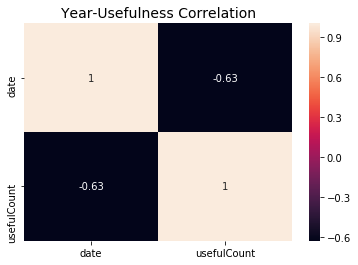

In [23]:
# Returns new dataframe with average useful count for each year
usefulness_df = drugs.groupby(drugs.date.dt.year).usefulCount.mean().to_frame().reset_index()

sns.heatmap(usefulness_df.corr(), annot=True)
plt.title('Year-Usefulness Correlation', fontSize=14)
plt.show()

**Conclusion**: Negative correlation between years and useful counts is not strong, but it's not totally random

### ANOVA test for `usefulCount` per year

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'usefulCount ~ C(year)'
lm = ols(formula, drugs).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq        df            F  PR(>F)
C(year)   4.104696e+07       9.0  4024.750995     0.0
Residual  2.423410e+08  213859.0          NaN     NaN


**Conclusion**: Test shows that there is a statistically significant difference in distribution of usefulness each year, hence I reject null hypothesis

### Rating Over the Years

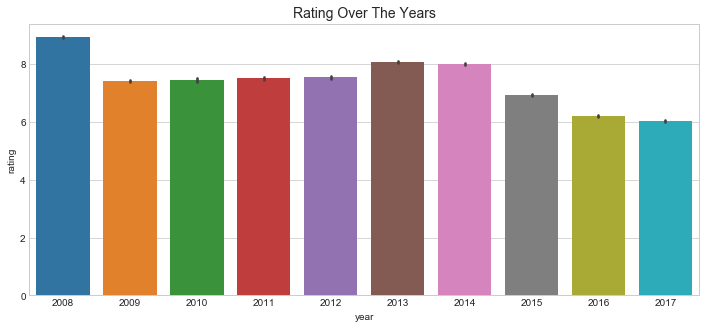

In [26]:
plt.figure(figsize=(12,5))
plt.style.use('seaborn-whitegrid')
sns.barplot(x='year', y='rating', data=drugs)
plt.title('Rating Over The Years', fontSize=14)
plt.show()

### Usefulness Over the Years

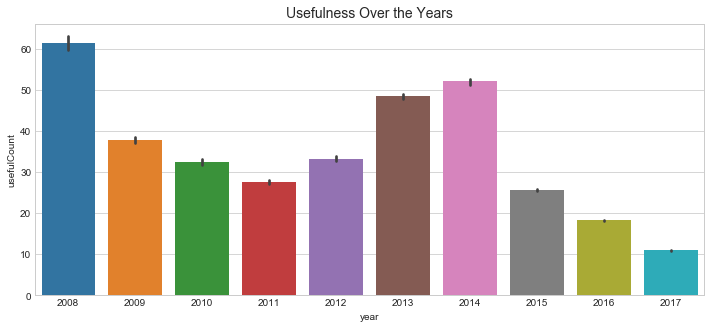

In [27]:
plt.figure(figsize=(12,5))
sns.barplot(x='year', y='usefulCount', data=drugs)
plt.title('Usefulness Over the Years', fontSize=14)
plt.show()

### Top 10 Drugs Usefulness Over the Years

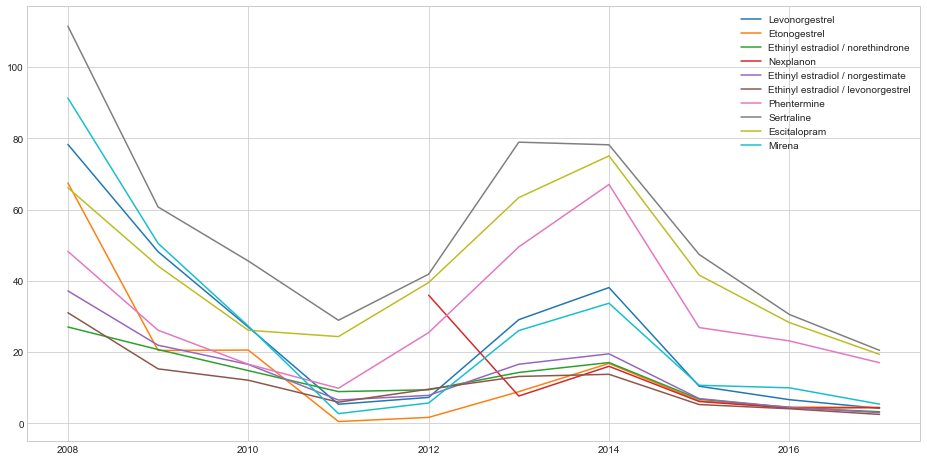

In [28]:
plt.figure(figsize=(16,8))

top_10_drugs = list(drugs.drugName.value_counts()[:10].keys())
for i in top_10_drugs:
    plt.plot(drugs[drugs.drugName==i].groupby('year').mean()[['usefulCount']], label=i)
    plt.legend()

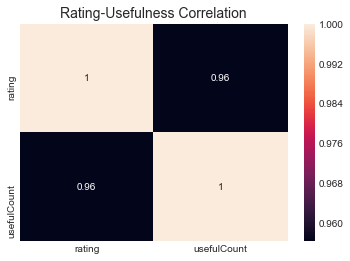

In [29]:
sns.heatmap(drugs.groupby('year')[['rating','usefulCount']].mean().corr(), annot=True)
plt.title('Rating-Usefulness Correlation', fontSize=14)
plt.show()

**Conclusion**: Reviews with higher rating appear to be more useful for users

### Distribution of Rating Across All Reviews

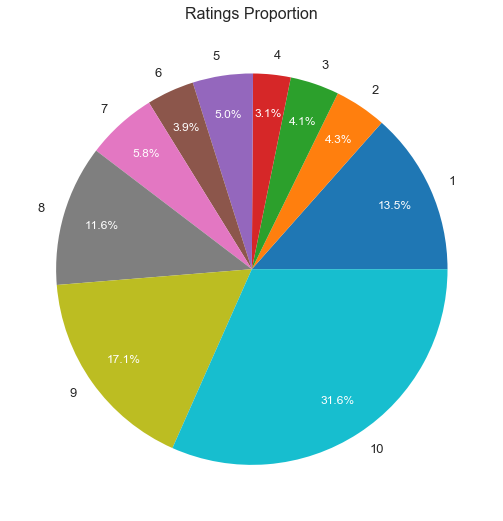

In [30]:
plt.figure(figsize=(9,9))

rating_count = drugs.groupby('rating')['review'].count()
sizes = rating_count.values
labels = rating_count.keys()

wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.1)
plt.setp(autotexts, size=12, color='w')
plt.setp(texts, size=13,)
plt.title('Ratings Proportion', fontSize=16)
plt.show()

**Conclusion**: patients tend to write a review when they have very good or very bad experience with medication. Approximately 60% of reviews have positive sentiment

### Top Rated Drugs For a Condition

In [31]:
def top_rated_drug_for_condition(condition='Depression', return_n=10):
    rating, count = [], []
    top_drugs = drugs[drugs.condition == condition].drugName.value_counts().head(return_n).keys()
    for i in top_drugs:
        rating.append(round(drugs[drugs.drugName==i].rating.mean(), 2))
        count.append(sum(drugs.drugName==i))
    return pd.DataFrame(np.array([top_drugs, rating, count]).T, columns=['Name','Rating','Count']).sort_values('Rating', ascending=False)

In [32]:
top_rated_drug_for_condition('Birth Control')

,Name,Rating,Count
2,Levonorgestrel,7.39,4896
8,Skyla,7.24,1076
7,Mirena,6.62,1673
6,Implanon,6.18,1506
9,Lo Loestrin Fe,6.07,914
0,Etonogestrel,5.83,4402
5,Ethinyl estradiol / norgestimate,5.79,2682
4,Ethinyl estradiol / levonorgestrel,5.76,2400
3,Nexplanon,5.64,2892
1,Ethinyl estradiol / norethindrone,5.58,3619


In [33]:
top_rated_drug_for_condition('Depression')

,Name,Rating,Count
5,Escitalopram,7.83,1739
6,Citalopram,7.6,1306
0,Bupropion,7.48,1360
1,Sertraline,7.45,1859
4,Pristiq,7.23,730
3,Desvenlafaxine,7.21,793
2,Venlafaxine,6.83,1332
9,Cymbalta,6.63,1142
8,Duloxetine,6.62,1251
7,Vortioxetine,6.13,681


# 4. Model

Deep Neural networks for classification problems based on text require some preprocessing for input layer. Each word must be transformed into token. Depends on the network, tokens would be represented as **matrix** of tokens (similar to hot encoding for categorical variables) or as **sequences**, where we preserve sentence structure.

In [5]:
def hot_pad_sequences(text, num_words=3000, maxlen=100):    
    tokenizer = Tokenizer(num_words)
    tokenizer.fit_on_texts(list(text))
    list_tokenized_headlines = tokenizer.texts_to_sequences(text)
    return sequence.pad_sequences(list_tokenized_headlines, maxlen)

In [6]:
def hot_tokenization(text, num_words=2000):
    tokenizer = Tokenizer(num_words)
    tokenizer.fit_on_texts(text)
    return tokenizer.texts_to_matrix(text, mode='binary')

In [7]:
def hot_label_encoding(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels_cat = le.transform(labels)
    return to_categorical(labels_cat) 

## 4.1 Predicting Condition Based on Review

### Selecting 10 most popular conditions

In [9]:
top_10_conditions = drugs.set_index('condition').loc[drugs.condition.value_counts()[:10].keys()]

### Hot Tokenization

In [40]:
X_t = hot_tokenization(top_10_conditions.lemm_review, 3000)
y = hot_label_encoding(top_10_conditions.index)
train, test, label_train, label_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

### Building Dense Network

In [42]:
backend.clear_session()

model = Sequential()
model.add(Embedding(3000, 100, input_length=100))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train, label_train, epochs=30, batch_size=256, validation_split=0.1)

history_dict = history.history
history_dict.keys()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 71080 samples, validate on 7898 samples
Epoch 1/30
71080/71080 [==============================] - 16s 222us/step - loss: 1.9556 - acc: 0.3650 - val_loss: 1.6991 - val_acc: 0.4009
Epoch 2/30
71080/71080 [==============================] - 9s 128us/step - loss: 1.5882 - acc: 0.4229 - val_loss: 1.4452 - val_acc: 0.4867
Epoch 3/30
71080/71080 [==============================] - 9s 125us/step - loss: 1.3801 - acc: 0.5173 - val_loss: 1.2693 - val_acc: 0.5785
Epoch 4/30
71080/71080 [==============================] - 9s 129us/step - loss: 1.2085 - acc: 0.6184 - val_loss: 1.1073 - val_acc: 0.6671
Epoch 5/30
71080/71080 [==============================] - 9s 126us/step - loss: 1.0454 - acc: 0.6980 - val_loss: 0.9561 - val_acc: 0.7250
Epoch 6/30
71080/71080 [==============================] - 9s 133us/step - loss: 0.9022 - acc: 0.7442 - val_loss: 0.8338 - val_acc: 0.7520
Ep

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

### Plot Results

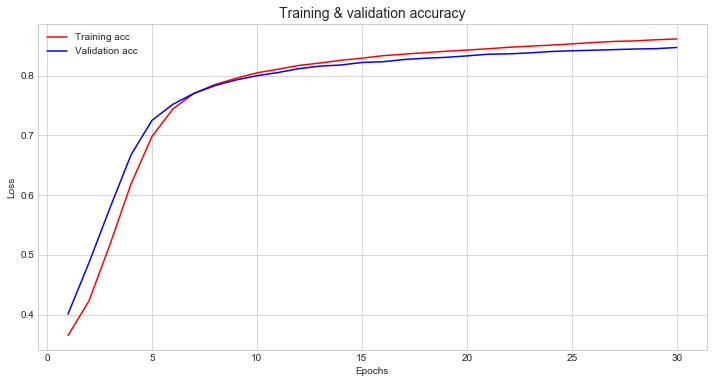

In [45]:
epochs = range(1, len(history_dict['acc']) + 1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['acc'], 'r', label='Training acc')
plt.plot(epochs, history_dict['val_acc'], 'blue', label='Validation acc')
plt.title('Training & validation accuracy', fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

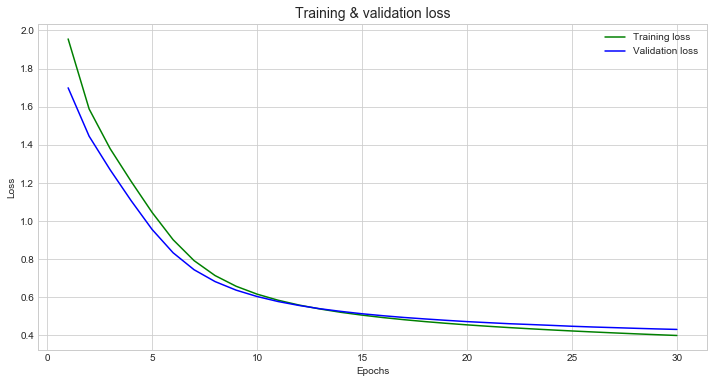

In [46]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['loss'], 'g', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'blue', label='Validation loss')

plt.title('Training & validation loss',fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluate Performance

In [47]:
model.evaluate(train, label_train)

78978/78978 [==============================] - 12s 147us/step


[0.39970333096838123, 0.8609992656182734]

In [48]:
model.evaluate(test, label_test)

19745/19745 [==============================] - 4s 183us/step


[0.429464601383679, 0.8505444416307926]

### Saving Model

In [49]:
model.save('models/top_10_conditions_30epochs.h5')

## 4.2 Sentiment prediction (Positive, Neutral, Negative)

Predict exact rating (1-10) from review would be very difficult and not so useful task.

In [10]:
def rate(x):
    return 'negative' if x < 4 else 'neutral' if x >= 4 and x < 7 else 'positive'

top_10_conditions['sentiment'] = top_10_conditions.rating.map(rate)

In [11]:
top_10_conditions.head()

,uniqueID,drugName,review,rating,date,usefulCount,year,lemm_review,sentiment
condition,,,,,,,,,
Birth Control,97768,Cyclafem 1 / 35,i have been on this birth control for one cyc...,9,2015-10-22,4,2015,ive first long recommend inactive effect pills...,positive
Birth Control,215892,Copper,i've had the copper coil for about months now...,6,2016-06-06,1,2016,nearly want think coil faint recommend side pa...,neutral
Birth Control,71428,Levora,i was on this pill for almost two years it do...,2,2011-04-16,3,2011,cry years first difference husband skin make a...,negative
Birth Control,79865,Blisovi Fe 1 / 20,i absolutely love this product and recommend ...,10,2017-11-03,4,2017,use recommend long cramp desire since consiste...,positive
Birth Control,60341,NuvaRing,i was on this for years and birth control pil...,7,2011-06-17,0,2011,friend might pills together drop impactful tel...,positive


### Preparing Sequences for the Model

In [8]:
X_t = hot_pad_sequences(top_10_conditions.review)
y = hot_label_encoding(top_10_conditions.sentiment)

In [9]:
train, test, label_train, label_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

### Model

In [10]:
backend.clear_session()

model = Sequential()
model.add(Embedding(3000, 100, input_length=100))
model.add(Conv1D(25, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          300000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 25)            12525     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)      

### Model Training

In [11]:
history = model.fit(train, label_train, epochs=3, batch_size=256, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 71080 samples, validate on 7898 samples
Epoch 1/3
71080/71080 [==============================] - 261s 4ms/step - loss: 0.6370 - acc: 0.7446 - val_loss: 0.5436 - val_acc: 0.7802
Epoch 2/3
71080/71080 [==============================] - 236s 3ms/step - loss: 0.4845 - acc: 0.8036 - val_loss: 0.4930 - val_acc: 0.8049
Epoch 3/3
71080/71080 [==============================] - 185s 3ms/step - loss: 0.3972 - acc: 0.8418 - val_loss: 0.4597 - val_acc: 0.8212


In [12]:
history_dict = history.history

### Model Visualization

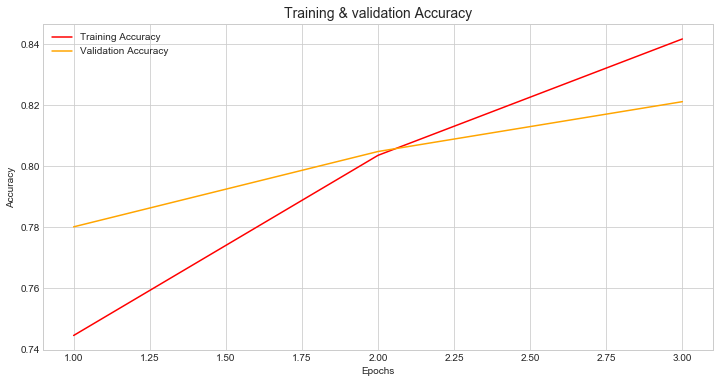

In [13]:
epochs = range(1, len(history_dict['acc']) + 1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['acc'], 'red', label='Training Accuracy')
plt.plot(epochs, history_dict['val_acc'], 'orange', label='Validation Accuracy')
plt.title('Training & validation Accuracy', fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

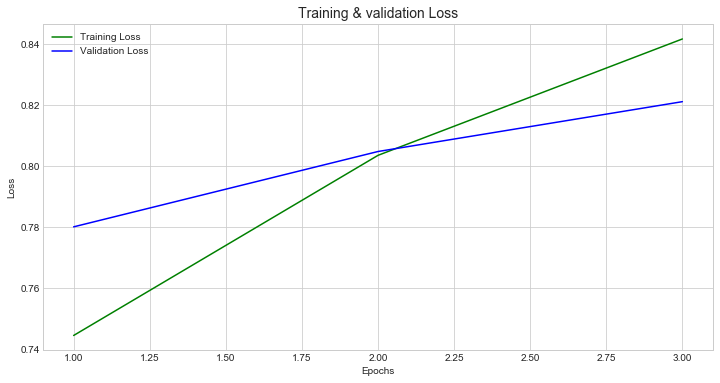

In [14]:
epochs = range(1, len(history_dict['acc']) + 1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['acc'], 'green', label='Training Loss')
plt.plot(epochs, history_dict['val_acc'], 'blue', label='Validation Loss')
plt.title('Training & validation Loss', fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.3 Predicting a Drug Based on Review

### Selecting 10 most popular drugs

In [101]:
top_drug_for_condition = []
for i in top_10_conditions.index.unique():
    drug_name = top_10_conditions[top_10_conditions.index==i].drugName.value_counts()[:1].keys()[0]
    top_drug_for_condition.append(drug_name)

In [102]:
top_drugs = pd.DataFrame()
for i in top_drug_for_condition:
    top_drugs = pd.concat([top_drugs, top_10_conditions[top_10_conditions.drugName==i]])

### Preparing Sequences for the Model

In [103]:
X_t = hot_pad_sequences(top_drugs.lemm_review, 3000, maxlen=100)
y = hot_label_encoding(top_drugs.drugName)
train, test, label_train, label_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

### Model Initialization

In [104]:
backend.clear_session()

model = Sequential()
model.add(Embedding(3000, 80, input_length=100))
model.add(Conv1D(60, 2, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 80)           240000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 60)            9660      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
Total para

### Training

In [105]:
history = model.fit(train, label_train, epochs=6, validation_split=0.1, batch_size=80)
history_dict = history.history

Train on 9332 samples, validate on 1037 samples
Epoch 1/6
9332/9332 [==============================] - 39s 4ms/step - loss: 1.7369 - acc: 0.4074 - val_loss: 1.0217 - val_acc: 0.7030
Epoch 2/6
9332/9332 [==============================] - 31s 3ms/step - loss: 0.6570 - acc: 0.8052 - val_loss: 0.3945 - val_acc: 0.8862
Epoch 3/6
9332/9332 [==============================] - 32s 3ms/step - loss: 0.3613 - acc: 0.8883 - val_loss: 0.3169 - val_acc: 0.8959
Epoch 4/6
9332/9332 [==============================] - 34s 4ms/step - loss: 0.2736 - acc: 0.9181 - val_loss: 0.2911 - val_acc: 0.8997
Epoch 5/6
9332/9332 [==============================] - 36s 4ms/step - loss: 0.2214 - acc: 0.9366 - val_loss: 0.2888 - val_acc: 0.9016
Epoch 6/6
9332/9332 [==============================] - 35s 4ms/step - loss: 0.1726 - acc: 0.9500 - val_loss: 0.2934 - val_acc: 0.9084


### Model Visualization

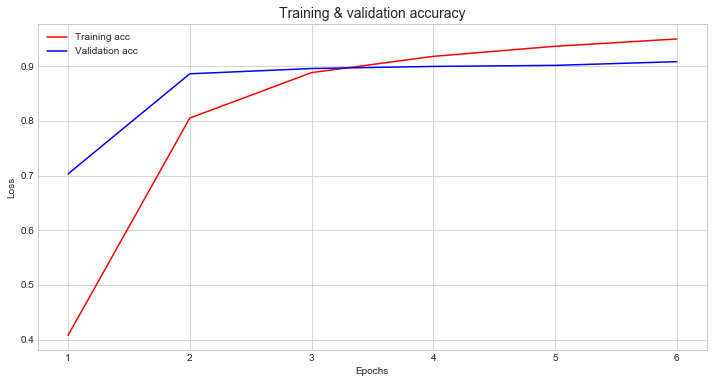

In [106]:
epochs = range(1, len(history_dict['acc']) + 1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['acc'], 'r', label='Training acc')
plt.plot(epochs, history_dict['val_acc'], 'blue', label='Validation acc')
plt.title('Training & validation accuracy', fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

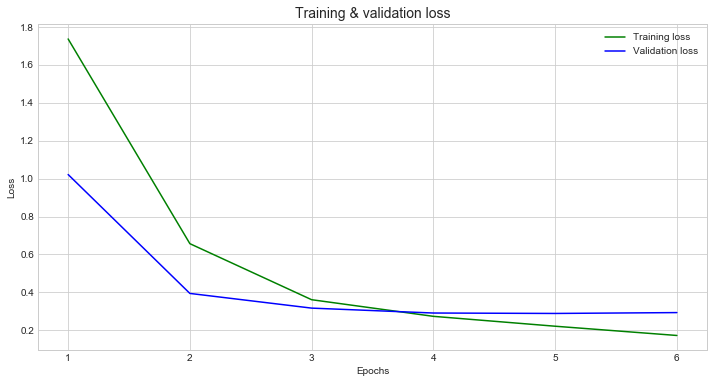

In [107]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['loss'], 'g', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'blue', label='Validation loss')

plt.title('Training & validation loss',fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
model.evaluate(train, label_train)

10369/10369 [==============================] - 14s 1ms/step


[0.11550691304210813, 0.9718391358858135]

In [109]:
model.evaluate(test, label_test)

2593/2593 [==============================] - 3s 1ms/step


[0.29553299349245304, 0.9032009255688391]

## 4.4 Predicting a Drug for Birth Control Based on Review

### Selecting Birth Control Drugs

In [119]:
top_birthcontrol_drugs = drugs.set_index('drugName').loc[drugs[drugs.condition=='Birth Control'].drugName.value_counts()[:10].keys()]

### Preparing Sequences for the Model

In [120]:
X_t = hot_pad_sequences(top_birthcontrol_drugs.lemm_review, 3000, maxlen=100)
y = hot_label_encoding(top_birthcontrol_drugs.index)
train, test, label_train, label_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

### Hypermarameteres Tuning

In [111]:
# Using function as a wrapper for a model to feed it into Keras Classifier with parameter we are about to tune
def create_model(dropout_rate=0.2, lr=0.01, conv_filters=25, kernel_size=5):
    backend.clear_session()
    model = Sequential()
    model.add(Embedding(3000, 80, input_length=100))
    model.add(Conv1D(conv_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])   
    return model
 
# Keras wrapper for skalearn `gridsearch`
model = KerasClassifier(build_fn=create_model)

# Parameters we are intersted in tuning
param_grid = dict(
                    dropout_rate = [0.1, 0.2],                
                    lr = [0.01, 0.1],
                    conv_filters = [20, 25],
                    kernel_size=[5, 10],
                    )

# Comparing models with different parameters, choosing best one
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train, label_train, verbose=1, epochs=3, validation_split=0.1)

print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Train on 9332 samples, validate on 1037 samples
Epoch 1/3
9332/9332 [==============================] - 28s 3ms/step - loss: 0.8207 - acc: 0.7200 - val_loss: 0.4382 - val_acc: 0.8554
Epoch 2/3
9332/9332 [==============================] - 25s 3ms/step - loss: 0.4195 - acc: 0.8597 - val_loss: 0.4399 - val_acc: 0.8611
Epoch 3/3
9332/9332 [==============================] - 26s 3ms/step - loss: 0.3415 - acc: 0.8894 - val_loss: 0.4822 - val_acc: 0.8611
Best Score: 0.866815 using {'conv_filters': 25, 'dropout_rate': 0.1, 'kernel_size': 5, 'lr': 0.01}


### Final Model With Tuned Hyperparameters

In [8]:
backend.clear_session()

model = Sequential()
model.add(Embedding(3000, 80, input_length=100))
model.add(Conv1D(25, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 80)           240000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 25)            10025     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
Total params: 251,475
Trainable params: 251,475
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = model.fit(train, label_train, epochs=6, validation_split=0.1, batch_size=80)

Train on 18763 samples, validate on 2085 samples
Epoch 1/6
18763/18763 [==============================] - 40s 2ms/step - loss: 1.3388 - acc: 0.4405 - val_loss: 1.0142 - val_acc: 0.5516
Epoch 2/6
18763/18763 [==============================] - 40s 2ms/step - loss: 1.0353 - acc: 0.5371 - val_loss: 0.9793 - val_acc: 0.5602
Epoch 3/6
18763/18763 [==============================] - 45s 2ms/step - loss: 0.9783 - acc: 0.5514 - val_loss: 0.9770 - val_acc: 0.5520
Epoch 4/6
18763/18763 [==============================] - 48s 3ms/step - loss: 0.9348 - acc: 0.5700 - val_loss: 0.9864 - val_acc: 0.5482
Epoch 5/6
18763/18763 [==============================] - 49s 3ms/step - loss: 0.9011 - acc: 0.5760 - val_loss: 0.9829 - val_acc: 0.5607
Epoch 6/6
18763/18763 [==============================] - 53s 3ms/step - loss: 0.8810 - acc: 0.5814 - val_loss: 0.9852 - val_acc: 0.5573


In [122]:
history_dict = history.history

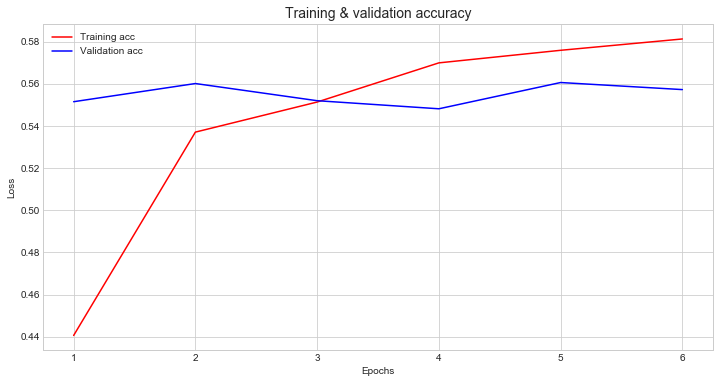

In [123]:
epochs = range(1, len(history_dict['acc']) + 1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['acc'], 'r', label='Training acc')
plt.plot(epochs, history_dict['val_acc'], 'blue', label='Validation acc')
plt.title('Training & validation accuracy', fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

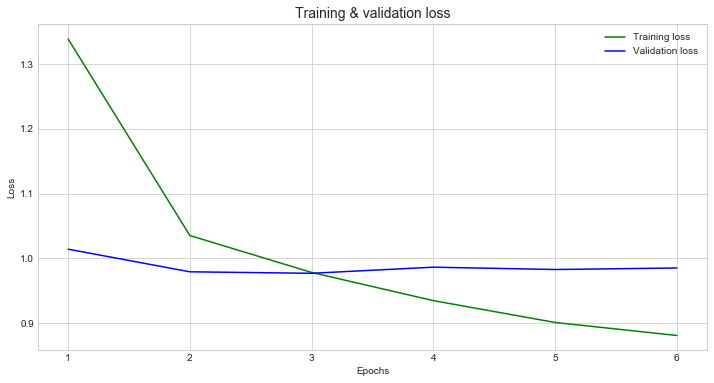

In [124]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

plt.plot(epochs, history_dict['loss'], 'g', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'blue', label='Validation loss')

plt.title('Training & validation loss',fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Validation

In [125]:
model.evaluate(train, label_train)

20848/20848 [==============================] - 21s 991us/step


[0.7638856178508386, 0.6176132003069839]

In [126]:
model.evaluate(test, label_test)

5212/5212 [==============================] - 5s 1ms/step


[1.0045669936072525, 0.5496930162538863]

**Conclusion**: random guess would give 10% prediction rate, model was able to achieve 55% on testing data, which is not bad considering the fact that drugs have similar effect on patients, hence they used similar words and phrases to describe their experience.

# 5. Interpret

### Advantages of preprocessing text data
Text data was cleared from punctuation, words were lemmatized, stop words removed. This step is necessary in most cases, giving several advantages to the model:
- make model more robust (keras Tokenizer select words based on frequency, hence removing unnecessary words gives model greater ability to learn from text)
- speed up learning process (less dimensions)

### Models performance
- Predicting condition based on review worked well with 3 layers dense network, scoring 85% accuracy given 30 epochs. Learning process slowed down after 10 epochs, but kept growing with insignificant overfitting. Used 3000 based on word frequency.
- Predicting sentiment scored 80% accuracy given 2 epochs. Further training resulted in overfitting.
- Predicting drug name based on review by using convolutional network scored 90% accuracy given 6 epochs. Learning process sharply slowed down after second epoch, making model overfitting on training data.
- Predicting drug name from the same group (Birth Control) resulted in 55% accuracy by using convolutional network with hyperparameters tuning. 

# Conclusion

- Statistical analysis uncovered relationship between rating of the drug and usefulness of the review: reviews with higher rating made them more popular among readers
- Approximately 60% of all reviews have positive sentiment, 
- Most popular drugs used for birth control
- Several types of neural networks (dense, convolutional) has been trained for classification problems with average accuracy of 80%. Higher accuracy was achieved by tuning hyperparameters

# Next Steps

- Detect side effects
- Use bigrams/trigrams in training process to increase accuracy